In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df= pd.read_csv("train.csv")

In [34]:
df

,date,store,item,demand
0,2013-01-01,1,1,46
1,2013-01-01,1,2,112
2,2013-01-01,1,3,83
3,2013-01-01,1,4,26
4,2013-01-01,1,5,86
...,...,...,...,...
912995,2017-12-31,10,46,48
912996,2017-12-31,10,47,67
912997,2017-12-31,10,48,37
912998,2017-12-31,10,49,82


In [35]:
df.head()

,date,store,item,demand
0,2013-01-01,1,1,46
1,2013-01-01,1,2,112
2,2013-01-01,1,3,83
3,2013-01-01,1,4,26
4,2013-01-01,1,5,86


In [36]:
df.columns

Index(['date', 'store', 'item', 'demand'], dtype='object')

In [37]:
df.shape

(913000, 4)

In [38]:
df.isna().sum()

date      0
store     0
item      0
demand    0
dtype: int64

In [39]:
df.dtypes

date      object
store      int64
item       int64
demand     int64
dtype: object

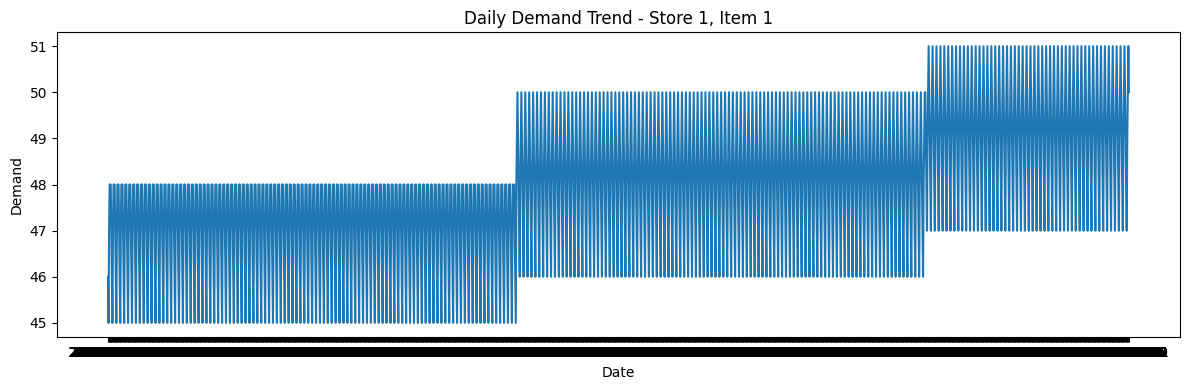

In [40]:
import matplotlib.pyplot as plt

# choose one product to visualize
store_id = 1
item_id = 1

plot_data = df[(df["store"] == store_id) & (df["item"] == item_id)]

plt.figure(figsize=(12,4))
plt.plot(plot_data["date"], plot_data["demand"])
plt.title(f"Daily Demand Trend - Store {store_id}, Item {item_id}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.tight_layout()
plt.show()

In [41]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["store", "item", "date"]).reset_index(drop=True)

In [42]:
df.dtypes

date      datetime64[ns]
store              int64
item               int64
demand             int64
dtype: object

In [43]:
df["dayofweek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [44]:
# Lag features (past demand)
df["lag_1"] = df.groupby(["store", "item"])["demand"].shift(1)
df["lag_7"] = df.groupby(["store", "item"])["demand"].shift(7)
df["lag_14"] = df.groupby(["store", "item"])["demand"].shift(14)

In [45]:
# rolling means must use shift(1) to avoid using today's demand to predict today
df["rolling_mean_7"] = (
    df.groupby(["store","item"])["demand"]
      .transform(lambda s: s.shift(1).rolling(7, min_periods=7).mean())
)
df["rolling_mean_14"] = (
    df.groupby(["store","item"])["demand"]
      .transform(lambda s: s.shift(1).rolling(14, min_periods=14).mean())
)


In [46]:
df = df.dropna().reset_index(drop=True)
df.head()

,date,store,item,demand,dayofweek,month,year,lag_1,lag_7,lag_14,rolling_mean_7,rolling_mean_14
0,2013-01-15,1,1,46,1,1,2013,47.0,46.0,46.0,47.0,47.0
1,2013-01-16,1,1,45,2,1,2013,46.0,45.0,45.0,47.0,47.0
2,2013-01-17,1,1,47,3,1,2013,45.0,47.0,47.0,47.0,47.0
3,2013-01-18,1,1,48,4,1,2013,47.0,48.0,48.0,47.0,47.0
4,2013-01-19,1,1,48,5,1,2013,48.0,48.0,48.0,47.0,47.0


In [47]:
FEATURES = [
    "store","item","dayofweek","month","year",
    "lag_1","lag_7","lag_14","rolling_mean_7","rolling_mean_14"
]
TARGET = "demand"

X = df[FEATURES]
y = df[TARGET]

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)


In [49]:
len(X_train), len(X_test)

(724800, 181200)

In [50]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",5
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [51]:
pred = model.predict(X_test)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R2  :", r2)

MAE : 0.09450965526703822
RMSE: 0.8068751972691246
R2  : 0.9996471713830734


In [63]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error

print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test  MAE:", mean_absolute_error(y_test, test_pred))

Train MAE: 0.006423830977372064
Test  MAE: 0.09450965526703824


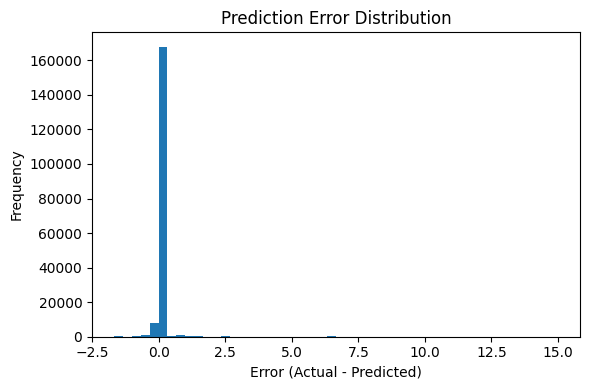

In [53]:
errors = y_test - model.predict(X_test)

plt.figure(figsize=(6,4))
plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [54]:
import joblib
joblib.dump(model, "demand_model.pkl")
joblib.dump(FEATURES, "model_features.pkl")
print("Saved demand_model.pkl and model_features.pkl")

Saved demand_model.pkl and model_features.pkl


In [55]:
store_id = 1
item_id = 1
data = df[(df["store"] == store_id) & (df["item"] == item_id)].sort_values("date")
last_row = data.iloc[-1]

In [56]:
X_last = last_row[FEATURES].to_frame().T
pred_demand = model.predict(X_last)[0]

In [57]:
current_inventory = 50      # user input
lead_time_days = 5          # supplier lead time
safety_days = 2             # buffer

In [58]:
# demand you expect to sell while waiting for new stock
lead_time_demand = pred_demand* lead_time_days

In [59]:
# safety stock based on recent average demand
safety_stock = pred_demand * safety_days

In [60]:
reorder_qty = max(0, lead_time_demand + safety_stock - current_inventory)

In [61]:
# decision
reorder_needed = "YES" if reorder_qty > 0 else "NO"


In [62]:
print("Predicted daily demand:", round(pred_demand, 2))
print("Reorder needed?:", reorder_needed)
print("Recommended reorder quantity:", round(reorder_qty, 2))

Predicted daily demand: 50.0
Reorder needed?: YES
Recommended reorder quantity: 300.0
